In [1]:
import numpy as np
import pickle
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
input_filename='/scratch/gpfs/jabbate/new_data/final_data_batch_0.pkl'
with open(input_filename, 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [4]:
from helpers.data_generator import process_data, DataGenerator

Using TensorFlow backend.


In [71]:
#import importlib
#importlib.reload(helpers.data_generator)
lookbacks={'dens':0,'temp':0,'density_estimate':6,'target_density':6,'gasA':6,'pinj':6}
lookahead=3
traindata, valdata, normalization_dict = process_data('/scratch/gpfs/jabbate/new_data/final_data_batch_204.pkl', #scenario['raw_data_path'],
                                                      list(lookbacks.keys()), #sig names
                                                      'RobustScaler',
                                                      1, #window length
                                                      0, #window overlap
                                                      lookbacks, #lookbacks
                                                      lookahead, #lookahead
                                                      1, #sample step
                                                      True, #uniform normalization
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      50, #nshots
                                                      2, #verbosity
                                                      True, #flattop only
                                                      randomize=False,
                                                      pruning_functions=['remove_nan','remove_non_gas_feedback']) #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                        
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                ['temp','dens'], #input profiles
                                ['target_density','gasA','pinj'], #actuators
                                ['dens'], #target profile names
                                ['density_estimate'], #scalar inputs
                                lookbacks, #lookbacks
                                lookahead,
                                True, #predict deltas
                                2, #profile_downsample
                                False) #scenario['shuffle_generators'])

Loading
Signals: dens, density_estimate, gasA, pinj, target_density, temp
Number of useable shots:  50
Number of shots used:  50
Total number of timesteps:  4986
Shots with Complete NaN: 
3198 samples total
Removing timesteps WITHOUT gas feedback
Removed 1409 samples
1789 samples remaining
Removing NaN
Removed 0 samples
1789 samples remaining
1789 samples remaining after pruning
Total number of samples:  1789
Number of training samples:  1789
Number of validation samples:  0


In [14]:
traindata['dens'].shape

(1789, 4, 65)

In [72]:
pre_pca=traindata['temp'][:,-1,:]

In [62]:
from sklearn import preprocessing
from sklearn import decomposition

In [73]:
pre_pca_normalized=pre_pca #preprocessing.scale(pre_pca)

In [74]:
pca=decomposition.PCA(n_components=3)
pca.fit(pre_pca_normalized)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

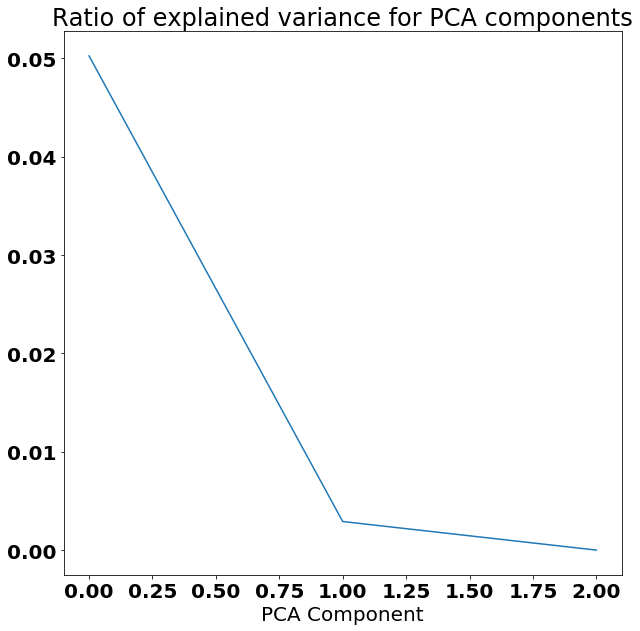

In [75]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

plt.plot(np.sum(pca.explained_variance_ratio_)-np.cumsum(pca.explained_variance_ratio_))
plt.title('Ratio of explained variance for PCA components')
plt.xlabel('PCA Component')
plt.show()

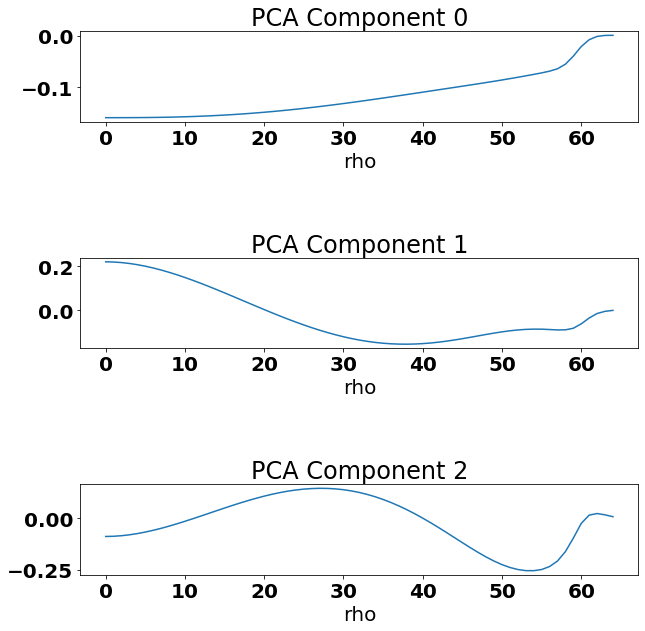

In [76]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
num_plots=min(9,len(pca.components_))
for i in range(num_plots):
    ax=fig.add_subplot('{}{}{}'.format(num_plots,1,i+1))
    ax.plot(pca.components_[i])
    ax.set_title('PCA Component {}'.format(i))
    ax.set_xlabel('rho')
plt.xlabel('rho',fontsize=20)
plt.subplots_adjust(hspace=1.5)

In [77]:
pca_data=pca.transform(pre_pca_normalized)

In [22]:
thomson_pca=pca.transform(data[0]['thomson_temp_EFITRT1'][:,-1,:])

NameError: name 'data' is not defined

Index 7



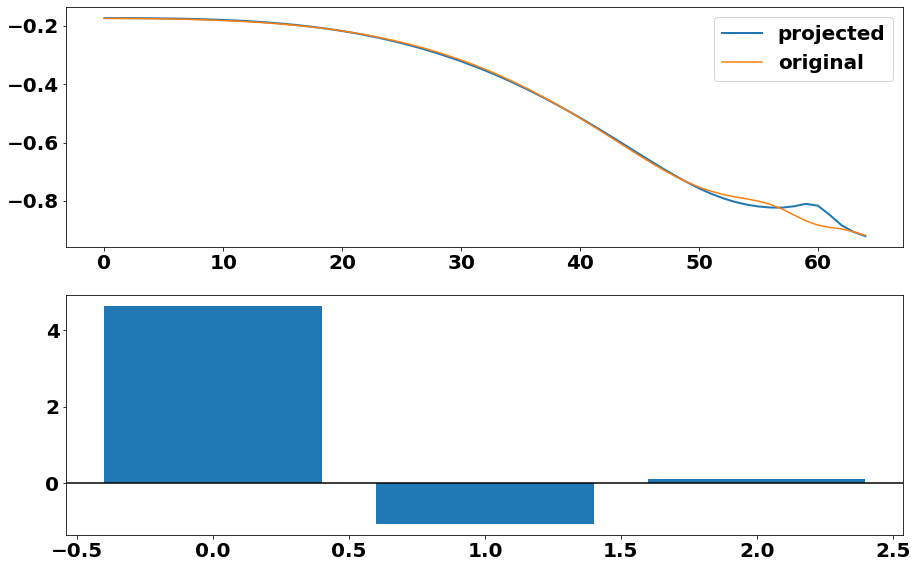

In [78]:
plt.rcParams['figure.figsize'] = [15, 15]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
ind=np.random.choice(len(pca_data))
ax=fig.add_subplot('311')
ax.plot(pca.inverse_transform(pca_data[ind]),label='projected',linewidth=2)
ax.plot(pre_pca_normalized[ind],label='original')
#ax.plot(data[0]['thomson_temp_EFITRT1'][ind,-1,:],label='thomson')
#ax.plot(pca.inverse_transform(thomson_pca[ind]),label='projected thomson',linewidth=2)
ax.legend()

ax=fig.add_subplot('312')
ax.bar([i for i  in range(len(pca_data[ind]))],pca_data[ind])
ax.axhline(0,color='k')

#ax=fig.add_subplot('313')
#ax.bar([i for i  in range(len(thomson_pca[ind]))],thomson_pca[ind])
#ax.axhline(0,color='k')

print('Index {}\n'.format(ind))

plt.show()

In [69]:
pre_pca_normalized.shape
pca_data.shape

(1789, 3)

Text(0, 0.5, 'Target Density')

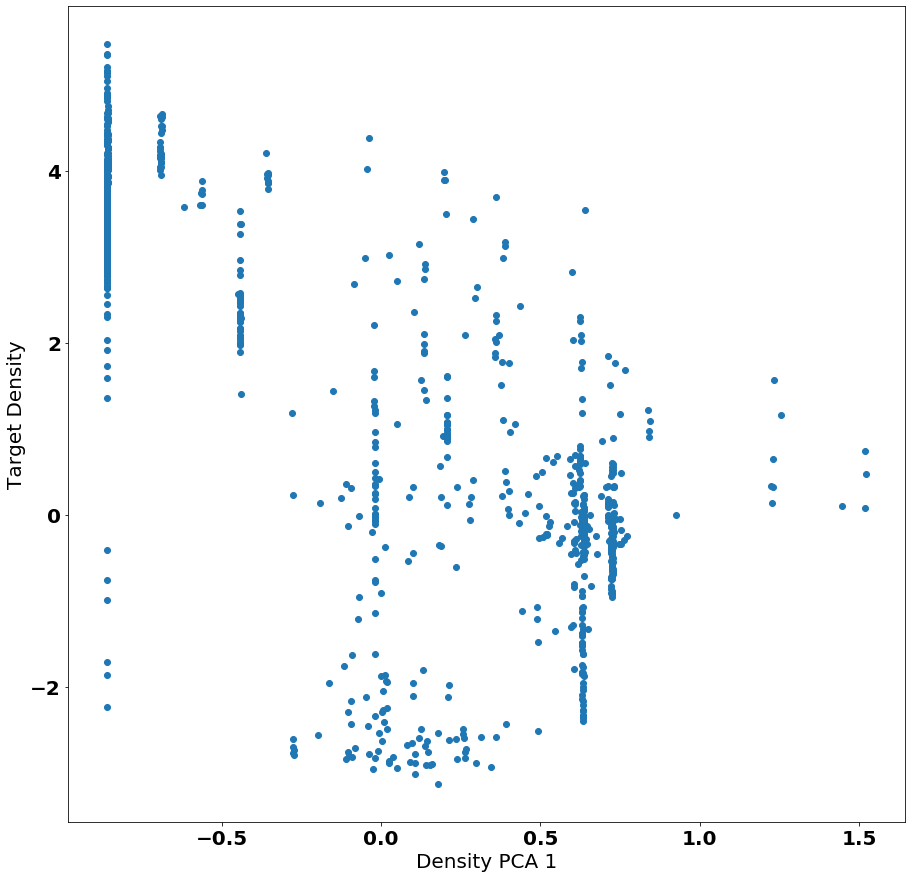

In [79]:
inds=range(1000)
plt.scatter(traindata['pinj'][inds,-1],pca_data[inds,0])
plt.xlabel('Density PCA 1')
plt.ylabel('Target Density')